In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df= pd.read_csv('CICDDoS2019.csv')
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


1. Data Preprocessing
1.1 Initial Cleaning

In [ ]:
print(df.columns.tolist())

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', 

In [ ]:
# Try stripping whitespace from column names
df.columns = df.columns.str.strip()

In [ ]:
# Drop unnecessary columns - with proper syntax
df.drop(['Flow ID', 'Source IP', 'Destination IP'], axis=1, inplace=True)

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Handle missing values
df.fillna(method='ffill', inplace=True)

<ipython-input-86-628450ff99d3>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


1.2 Feature Engineering

In [ ]:
# Convert labels to binary (case-insensitive)
print("\nOriginal label values:", df['Label'].unique())

label_mapping = {
    'benign': 0, 'benign': 0, 'BENIGN': 0,
    'attack': 1, 'Attack': 1, 'ATTACK': 1
}
df['Label'] = df['Label'].map(label_mapping).fillna(1)  # Assume anything not benign is attack

print("Converted label values:", df['Label'].unique())
print("Class distribution:")
print(df['Label'].value_counts())


Original label values: ['BENIGN' 'DDoS']
Converted label values: [0. 1.]
Class distribution:
Label
1.0    128027
0.0     97718
Name: count, dtype: int64


In [ ]:
# Create time-based features
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)



In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns (excluding label)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in numerical_cols:
    numerical_cols.remove('Label')

# Clean infinite values
df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Normalize features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nAfter normalization:")
print(df[numerical_cols].describe().loc[['min', 'max']])


After normalization:
     Source Port  Destination Port  Protocol  Flow Duration  \
min          0.0               0.0       0.0            0.0   
max          1.0               1.0       1.0            1.0   

     Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
min                0.0                     0.0                          0.0   
max                1.0                     1.0                          1.0   

     Total Length of Bwd Packets  Fwd Packet Length Max  \
min                          0.0                    0.0   
max                          1.0                    1.0   

     Fwd Packet Length Min  ...  Active Std  Active Max  Active Min  \
min                    0.0  ...         0.0         0.0         0.0   
max                    1.0  ...         1.0         1.0         1.0   

     Idle Mean  Idle Std  Idle Max  Idle Min  hour  day_of_week  is_weekend  
min        0.0       0.0       0.0       0.0   0.0          0.0         0.0  
ma

2. Time Series Transformation
2.1 Aggregating to Time Intervals

In [ ]:
# Set timestamp as index and resample
df.set_index('Timestamp', inplace=True)
time_series = df.resample('1T').agg({
    'Label': 'mean',
    'Flow Bytes/s': 'mean',
    'Flow Packets/s': 'mean',
    'Total Fwd Packets': 'sum',
    'Total Backward Packets': 'sum'
})

# Create binary attack label
time_series['Attack'] = (time_series['Label'] > 0.5).astype(int)

print("\nTime series shape:", time_series.shape)
print("\nTime series head:")
print(time_series.head())


Time series shape: (93, 6)

Time series head:
                     Label  Flow Bytes/s  Flow Packets/s  Total Fwd Packets  \
Timestamp                                                                     
2017-07-07 03:30:00    0.0      0.006341        0.409341           9.805800   
2017-07-07 03:31:00    0.0      0.006217        0.406935           6.039358   
2017-07-07 03:32:00    0.0      0.008009        0.418204           0.851372   
2017-07-07 03:33:00    0.0      0.006427        0.408701           3.515277   
2017-07-07 03:34:00    0.0      0.006412        0.409649           2.338167   

                     Total Backward Packets  Attack  
Timestamp                                            
2017-07-07 03:30:00                7.790619       0  
2017-07-07 03:31:00                4.741672       0  
2017-07-07 03:32:00                0.635282       0  
2017-07-07 03:33:00                2.673691       0  
2017-07-07 03:34:00                1.773623       0  


<ipython-input-90-d08adbdf5863>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_series = df.resample('1T').agg({


2.2 Stationarity Check

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity for key features
for col in ['Flow Bytes/s', 'Flow Packets/s']:
    if col in time_series.columns:
        result = adfuller(time_series[col].dropna())
        print(f"\n{col} stationarity test:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        if result[1] > 0.05:
            time_series[f'{col}_diff'] = time_series[col].diff().dropna()
            print(f"Created differenced version: {col}_diff")


Flow Bytes/s stationarity test:
ADF Statistic: -4.5847
p-value: 0.0001

Flow Packets/s stationarity test:
ADF Statistic: -2.3046
p-value: 0.1705
Created differenced version: Flow Packets/s_diff


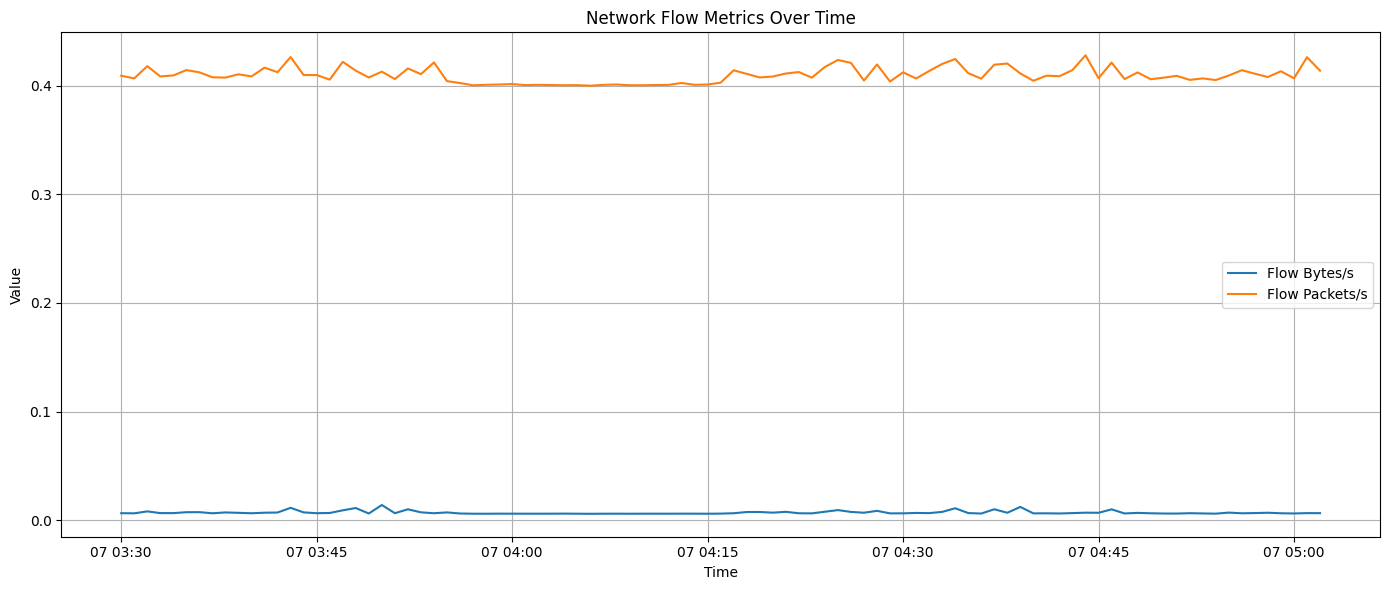

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for col in ['Flow Bytes/s', 'Flow Packets/s']:
    if col in time_series.columns:
        plt.plot(time_series.index, time_series[col], label=col)

plt.title('Network Flow Metrics Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3. Feature Selection for Time Series


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

print("\nRunning Granger causality tests...")
maxlag = 12
test = 'ssr_chi2test'
causal_features = []

for feature in [col for col in time_series.columns if col != 'Attack']:
    try:
        # Ensure we have enough data points
        test_data = time_series[[feature, 'Attack']].dropna()
        if len(test_data) < maxlag * 2:
            print(f"Skipping {feature} - insufficient data")
            continue

        gc_res = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
        p_values = [round(gc_res[i+1][0][test][1], 4) for i in range(maxlag)]

        if min(p_values) < 0.05:
            causal_features.append(feature)
            print(f"{feature}: Significant (min p-value={min(p_values):.4f})")

    except Exception as e:
        print(f"Skipped {feature}: {str(e)}")

# Fallback if no significant features
if not causal_features:
    print("\nNo significant features found - using top 5 most variable features")
    causal_features = time_series.drop(columns=['Attack', 'Label']).var().nlargest(5).index.tolist()

print("\nSelected causal features:", causal_features)


Running Granger causality tests...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Label: Significant (min p-value=0.0000)
Flow Bytes/s: Significant (min p-value=0.0002)
Flow Packets/s: Significant (min p-value=0.0000)
Total Fwd Packets: Significant (min p-value=0.0000)
Total Backward Packets: Significant (min p-value=0.0000)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Flow Packets/s_diff: Significant (min p-value=0.0040)

Selected causal features: ['Label', 'Flow Bytes/s', 'Flow Packets/s', 'Total Fwd Packets', 'Total Backward Packets', 'Flow Packets/s_diff']


In [ ]:
# Prepare target and features
target = time_series['Attack']
features = time_series[causal_features] if causal_features else None

print("\nFinal data shapes:")
print("Target:", target.shape)
if features is not None:
    print("Features:", features.shape)


Final data shapes:
Target: (93,)
Features: (93, 6)


In [ ]:
# Drop any remaining NaNs or infs from features and target
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(method='ffill').fillna(method='bfill')  # Use both directions if needed

# Ensure target is also clean
target = target.fillna(method='ffill').fillna(method='bfill')


<ipython-input-106-bd1590af5f40>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(method='bfill')  # Use both directions if needed
<ipython-input-106-bd1590af5f40>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = target.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Visualiser la distribution des classes dans la cible
print("\nDistribution des classes de 'Attack':")
print(target.value_counts())



Distribution des classes de 'Attack':
Attack
0    73
1    20
Name: count, dtype: int64


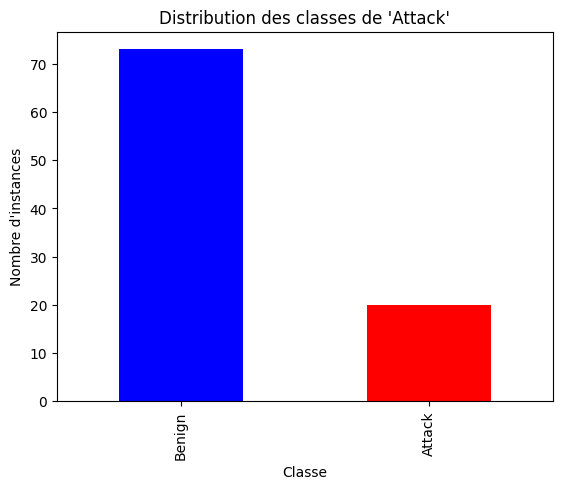

In [ ]:
import matplotlib.pyplot as plt

# Personnalisation des labels
class_names = {0: 'Benign', 1: 'Attack'}

# Affichage de la distribution avec un graphique
ax = target.value_counts().plot(kind='bar', title="Distribution des classes de 'Attack'", color=['blue', 'red'])

# Ajouter les étiquettes et améliorer le graphique
ax.set_xlabel('Classe')
ax.set_ylabel('Nombre d\'instances')
ax.set_xticklabels([class_names[int(i)] for i in ax.get_xticks()])  # Remplacer les indices par les labels
ax.set_title("Distribution des classes de 'Attack'")

# Afficher le graphique
plt.show()



4.ARFIMA Model Implementation

In [ ]:
!pip install pmdarima


In [ ]:
!pip install arch

In [ ]:
# 4. ARFIMA Model Implementation

# Assurez-vous que pmdarima est bien installé :
# !pip install pmdarima

import pmdarima as pm
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import numpy as np

print("\nStarting ARFIMA modeling with pmdarima...")

# Appliquer un modèle ARFIMA avec auto_arima
model = pm.auto_arima(
    target,
    exogenous=features,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,                  # Laisse pmdarima estimer le paramètre d (différentiation fractionnaire)
    seasonal=False,          # Pas de saisonnalité ici
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

# Prédictions
forecast = model.predict_in_sample(exogenous=features)
predictions = (forecast > 0.5).astype(int)

# Évaluation
print("\nModel Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(target, predictions))
print("\nClassification Report:")
print(classification_report(target, predictions))

# Coefficients du modèle ARFIMA
print("\nARFIMA Model Summary:")
print(model.summary())

# Calcul du RMSE
rmse1 = np.sqrt(mean_squared_error(target, forecast))
print(f"\nRMSE: {rmse1:.4f}")
# Assurez-vous que pmdarima est bien installé :
# !pip install pmdarima

import pmdarima as pm
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import numpy as np

print("\nStarting ARFIMA modeling with pmdarima...")

# Appliquer un modèle ARFIMA avec auto_arima
model = pm.auto_arima(
    target,
    exogenous=features,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,                  # Laisse pmdarima estimer le paramètre d (différentiation fractionnaire)
    seasonal=False,          # Pas de saisonnalité ici
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

# Prédictions
forecast = model.predict_in_sample(exogenous=features)
predictions = (forecast > 0.5).astype(int)

# Évaluation
print("\nModel Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(target, predictions))
print("\nClassification Report:")
print(classification_report(target, predictions))

# Coefficients du modèle ARFIMA
print("\nARFIMA Model Summary:")
print(model.summary())

# Calcul du RMSE
rmse1 = np.sqrt(mean_squared_error(target, forecast))
print(f"\nRMSE: {rmse1:.4f}")



Starting ARFIMA modeling with pmdarima...
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-87.310, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=122.994, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-89.257, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.110, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-87.313, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.268, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-87.900, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.247 seconds

Model Evaluation:
Confusion Matrix:
[[72  1]
 [ 1 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.95      0.95      0.95        20

    accuracy                           0.98        93
   macro avg       0.97      0.97      0.97        93
weighted avg       0.98      0.98      0.98        93


ARFIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  46.628
Date:                Thu, 17 Apr 2025   AIC                            -89.257
Time:                        16:50:12   BIC    

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-87.310, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=122.994, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-89.257, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.110, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-87.313, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.268, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-87.900, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.702 seconds

Model Evaluation:
Confusion Matrix:
[[72  1]
 [ 1 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.95      0.95      0.95        20

    accuracy                           0.98        93
   macro avg       0.97      0.97      0.97        93
weighted avg       0.98      0.98      0.98        93


ARFIMA Model Summary:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  46.628
Date:                Thu, 17 Apr 2025   AIC                            -89.257
Time:                        16:50:14   BIC                            -84.192
Sample:                    07-07-2017   HQIC                           -87.212
                         - 07-07-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9413      0.027     34.354      0.000       0.888       0.995
sigma2         0.0210      0.001     24.326      0.000       0.019       0.023
Ljung-Box (L1) (Q):                   0.07   Jarque-


=== Final Results ===
Time period analyzed: 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Total observations: 93
Attack percentage: 21.51%

Top predictive features:
1. Label
2. Flow Bytes/s
3. Flow Packets/s
4. Total Fwd Packets
5. Total Backward Packets

Model diagnostics:


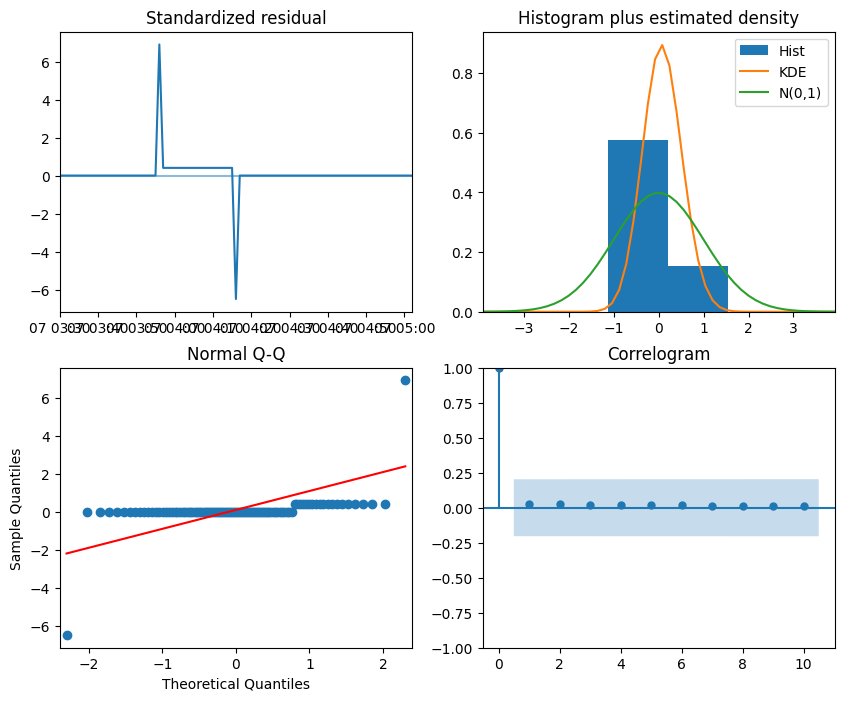

In [ ]:
print("\n=== Final Results ===")
print(f"Time period analyzed: {time_series.index[0]} to {time_series.index[-1]}")
print(f"Total observations: {len(time_series)}")
print(f"Attack percentage: {time_series['Attack'].mean():.2%}")
print("\nTop predictive features:")
for i, feat in enumerate(causal_features[:5], 1):
    print(f"{i}. {feat}")

if 'model' in locals():
    print("\nModel diagnostics:")
    try:
        model.plot_diagnostics(figsize=(10,8))
    except:
        print("Could not generate diagnostics plot")

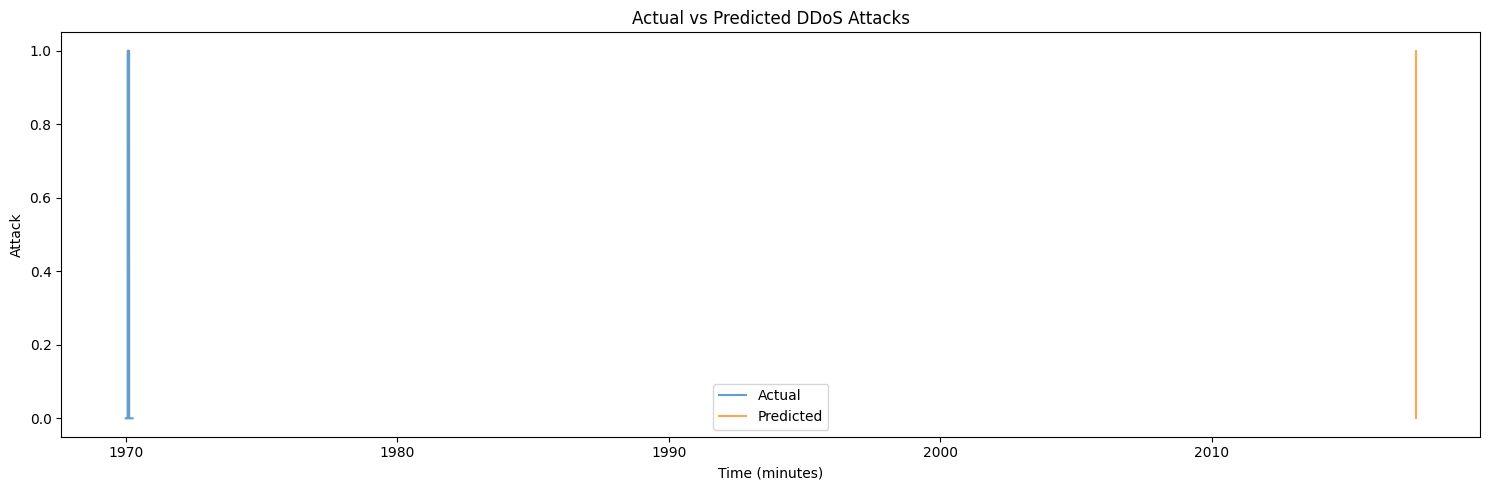

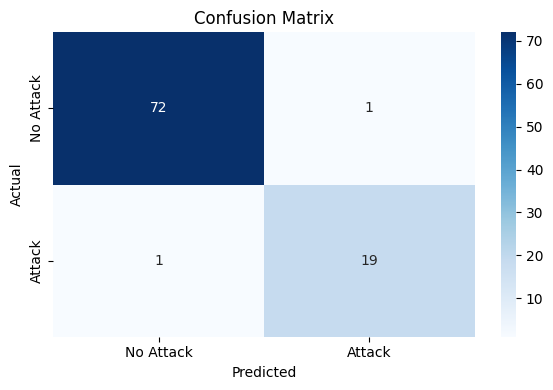

In [ ]:
# 5. Visualization & Final Insights

import matplotlib.pyplot as plt
import seaborn as sns

# Plot actual vs predicted
plt.figure(figsize=(15,5))
plt.plot(target.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted DDoS Attacks')
plt.xlabel('Time (minutes)')
plt.ylabel('Attack')
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap of confusion matrix
conf_mat = confusion_matrix(target, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [ ]:
!pip install prophet


In [ ]:
!pip install pystan


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import numpy as np

# Créer et ajuster un modèle ARIMA sur la target avec les mêmes exogènes
arima_model = ARIMA(endog=target, exog=features, order=(1, 0, 1))  # à ajuster si nécessaire
arima_result = arima_model.fit()

# Prédiction in-sample
arima_forecast = arima_result.predict(start=0, end=len(target)-1, exog=features)
arima_predictions = (arima_forecast > 0.5).astype(int)

# Évaluation
print("\nARIMA Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(target, arima_predictions))
print("\nClassification Report:")
print(classification_report(target, arima_predictions))

# RMSE
arima_rmse = np.sqrt(mean_squared_error(target, arima_forecast))
print(f"\nARIMA RMSE: {arima_rmse:.4f}")




ARIMA Evaluation:
Confusion Matrix:
[[72  1]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        73
           1       0.95      1.00      0.98        20

    accuracy                           0.99        93
   macro avg       0.98      0.99      0.98        93
weighted avg       0.99      0.99      0.99        93


ARIMA RMSE: 0.0669


ARIMA RMSE: 0.0669
ARFIMA RMSE: 0.1449


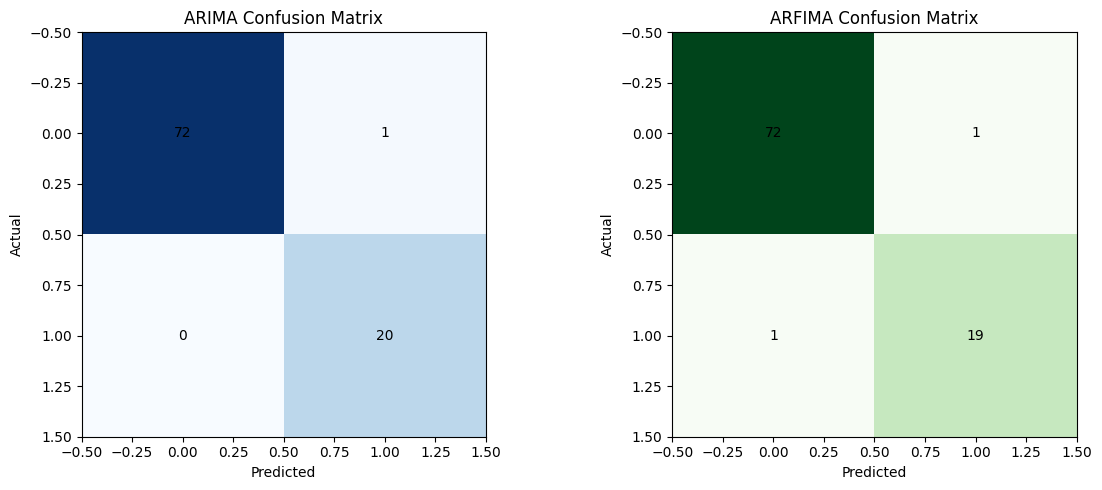

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt

# ========= Résumé Comparatif =========
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARFIMA RMSE: {rmse1:.4f}")  # celui que tu as déjà imprimé

# Bonus : Matrice de confusion combinée
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ARIMA
cm_arima = confusion_matrix(target, arima_predictions)
axs[0].imshow(cm_arima, cmap='Blues')
axs[0].set_title("ARIMA Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# Annoter les valeurs
for i in range(cm_arima.shape[0]):
    for j in range(cm_arima.shape[1]):
        axs[0].text(j, i, str(cm_arima[i, j]), va='center', ha='center', color='black')

# ARFIMA
cm_arfima = confusion_matrix(target, predictions)
axs[1].imshow(cm_arfima, cmap='Greens')
axs[1].set_title("ARFIMA Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

# Annoter les valeurs
for i in range(cm_arfima.shape[0]):
    for j in range(cm_arfima.shape[1]):
        axs[1].text(j, i, str(cm_arfima[i, j]), va='center', ha='center', color='black')

plt.tight_layout()
plt.show()


